# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [119]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

Text(0.5, 0, 'Date (Week)')

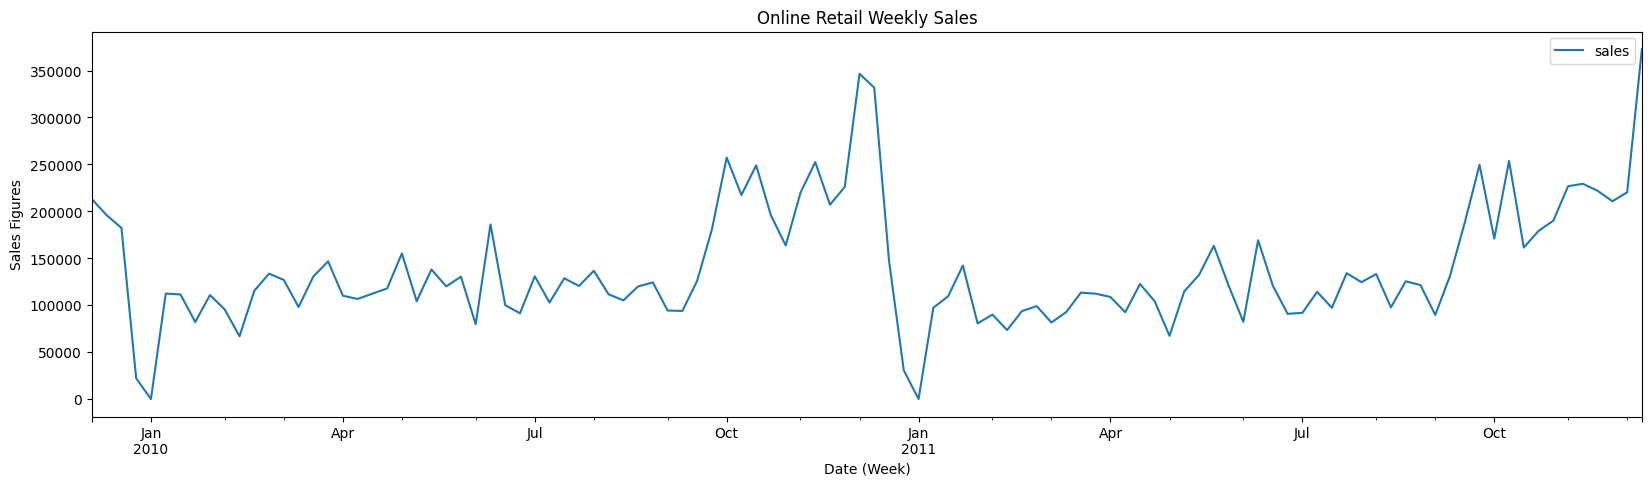

In [120]:
# plot the time series
df.plot(figsize=(20,5))
plt.title('Online Retail Weekly Sales')
plt.ylabel('Sales Figures')
plt.xlabel('Date (Week)')

sales reset at the beginning of the year

## Missing data

Check if there are missing values in the time series.

In [121]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

Text(0.5, 0, 'Date (Week)')

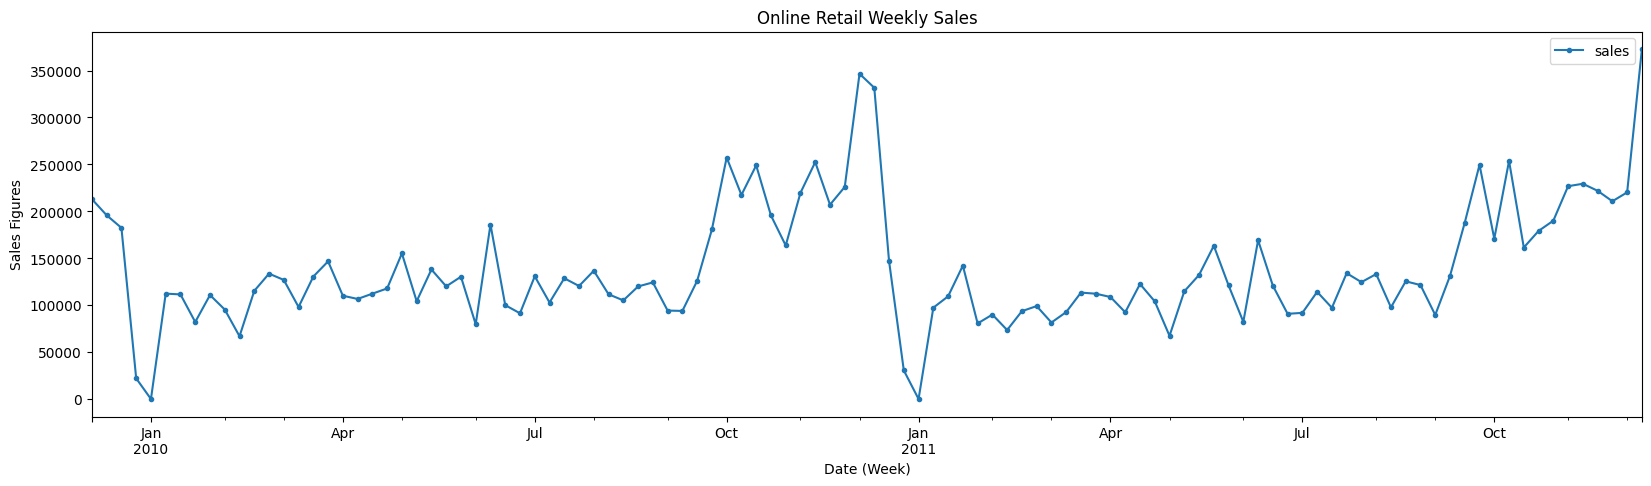

In [122]:
# give the time series weekly frequency
df_ = df.asfreq('W')

# if there are missing values, forward fill them
df_imputed = df_.fillna(method='ffill')

# plot to see if there is any missing values imputed

# plot original time series
ax = df_.plot(linestyle='-', marker='.', figsize=(20,5))

# overlay imputed time series over original time series
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

# plot customisation
plt.title('Online Retail Weekly Sales')
plt.ylabel('Sales Figures')
plt.xlabel('Date (Week)')

no missing values observed in data set, if there are missing values, they would appear as red color data points in the plot.

## Seasonality

Does the time series show any obvious seasonal pattern?

Text(0.5, 0, 'Date (Month)')

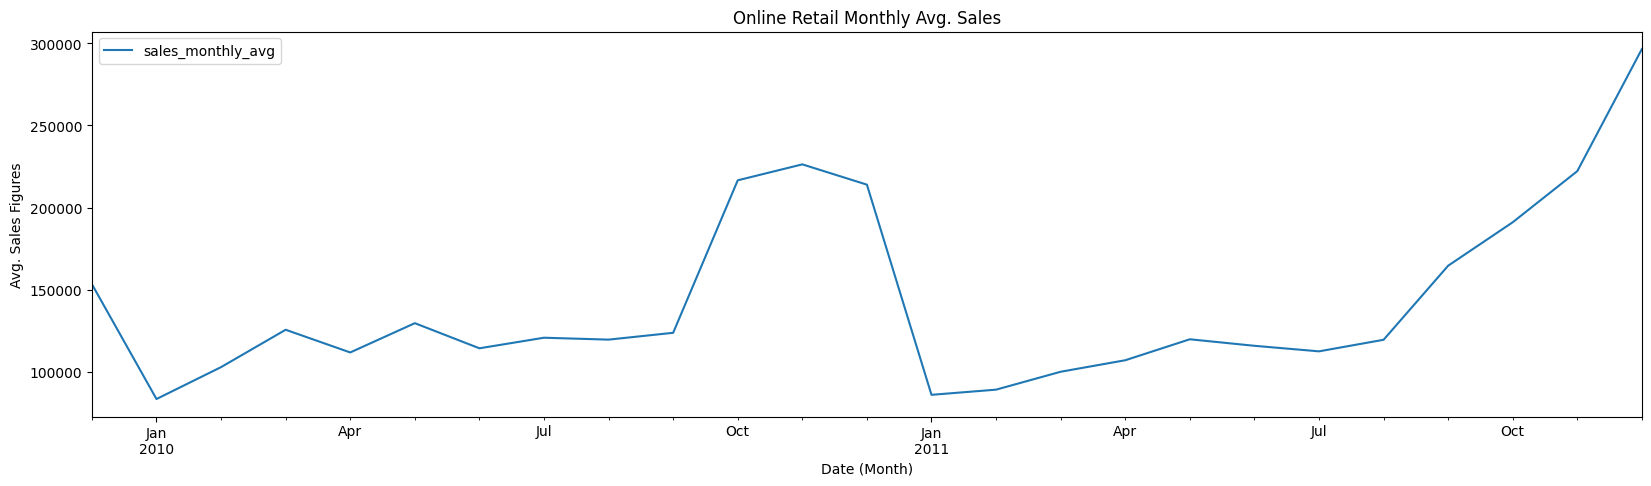

In [123]:
# group weekly sales into monthly sales and calculate monthly avg
df_monthly_avg = df.resample('M').mean().rename(columns={'sales':'sales_monthly_avg'})

# plot the monthly average sales figure
df_monthly_avg.plot(figsize=(20,5))
plt.title('Online Retail Monthly Avg. Sales')
plt.ylabel('Avg. Sales Figures')
plt.xlabel('Date (Month)')

Text(0.5, 0, 'Date (Month)')

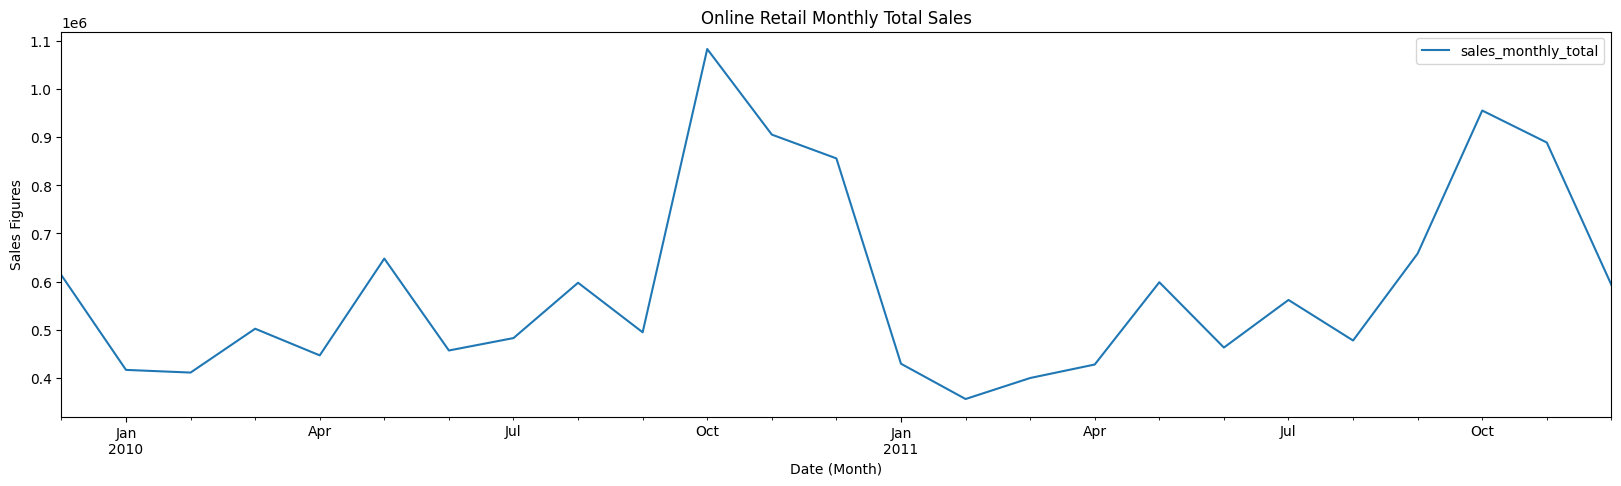

In [124]:
# group weekly sales into monthly sales and calculate monthly avg
df_monthly_avg = df.resample('M').sum().rename(columns={'sales':'sales_monthly_total'})

# plot the monthly average sales figure
df_monthly_avg.plot(figsize=(20,5))
plt.title('Online Retail Monthly Total Sales')
plt.ylabel('Sales Figures')
plt.xlabel('Date (Month)')

On a monthly basis, sales tends to peak on Oct and dips after Dec. This is observed through the monthly avgerage and total sales plots above.

# Feature engineering

Now, let's begin to tabularize the data.

In [125]:
# extract datetime components from dataframe index
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week

# find out if the day happen to be on the weekend (fri-sun)
df['is_weekend'] = np.where(df['day']>4, 1, 0)

In [127]:
# create lag features shifting sales figures by 1 week
df['sales_week_-1'] = df['sales'].shift(freq='1W')

# create window features using average sales of previous 2 weeks
df['sales_avg_week_-2'] = df['sales'].rolling(window=2).mean().shift(freq='2W')

# drop missing values in dataframe
df.dropna(inplace=True)

In [192]:
df

,sales,year,month,day,week_of_year,is_weekend,sales_week_-1,sales_avg_week_-2
week,,,,,,,,
2009-12-27,22007.770,2009,12,27,52,1,182396.74,204405.195
2010-01-03,0.000,2010,1,3,53,0,22007.77,189103.390
2010-01-10,112318.850,2010,1,10,1,1,0.00,102202.255
2010-01-17,111460.470,2010,1,17,2,1,112318.85,11003.885
2010-01-24,82065.331,2010,1,24,3,1,111460.47,56159.425
...,...,...,...,...,...,...,...,...
2011-11-13,229378.010,2011,11,13,45,1,226770.53,184570.135
2011-11-20,221870.290,2011,11,20,46,1,229378.01,208402.365
2011-11-27,210741.760,2011,11,27,47,1,221870.29,228074.270


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [135]:
# all dates before 2011-Oct = train
# all dates from 2011-Oct = test
train_df = df[df.index < '2011-10-01']
test_df = df[df.index >= '2011-10-01']

# check the start and end for both train and test
print('start of training: ', train_df.index.min())
print('end of training: ', train_df.index.max())
print('start of testing: ', test_df.index.min())
print('end of testing: ', test_df.index.max())

start of training:  2009-12-27 00:00:00
end of training:  2011-09-25 00:00:00
start of testing:  2011-10-02 00:00:00
end of testing:  2011-12-11 00:00:00


In [138]:
# prepare training and testing inputs for forecast
X_train, y_train = train_df.drop('sales', axis=1), train_df['sales']
X_test, y_test = test_df.drop('sales', axis=1), test_df['sales']

print('shape of training: ', X_train.shape, y_train.shape)
print('shape of testing: ', X_test.shape, y_test.shape)

shape of training:  (92, 7) (92,)
shape of testing:  (11, 7) (11,)


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [143]:
train_rmse = mean_squared_error(y_train, X_train['sales_week_-1'], squared=False)
test_rmse = mean_squared_error(y_test, X_test['sales_week_-1'], squared=False)

print('train rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train rmse:  48564.09587456346
test_rmse:  65327.34284108387


## Machine Learning

In [145]:
# define some constants
RANDOM_STATE = 2    

In [179]:
# first iteration, random forest regressor
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=4,
    random_state = RANDOM_STATE
)

# fit the training data into model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=200, random_state=2)

In [180]:
# perform predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# evaluate performance of model
rf_train_rmse = mean_squared_error(y_train, rf_train_pred, squared=False)
rf_test_rmse = mean_squared_error(y_test, rf_test_pred, squared=False)

# print the results
print('RMSE of model performance on training data: ', rf_train_rmse)
print('RMSE of model performance on testing data: ', rf_test_rmse)

RMSE of model performance on training data:  23277.16810494534
RMSE of model performance on testing data:  52684.28210984027


Text(0.5, 0, 'Input Features')

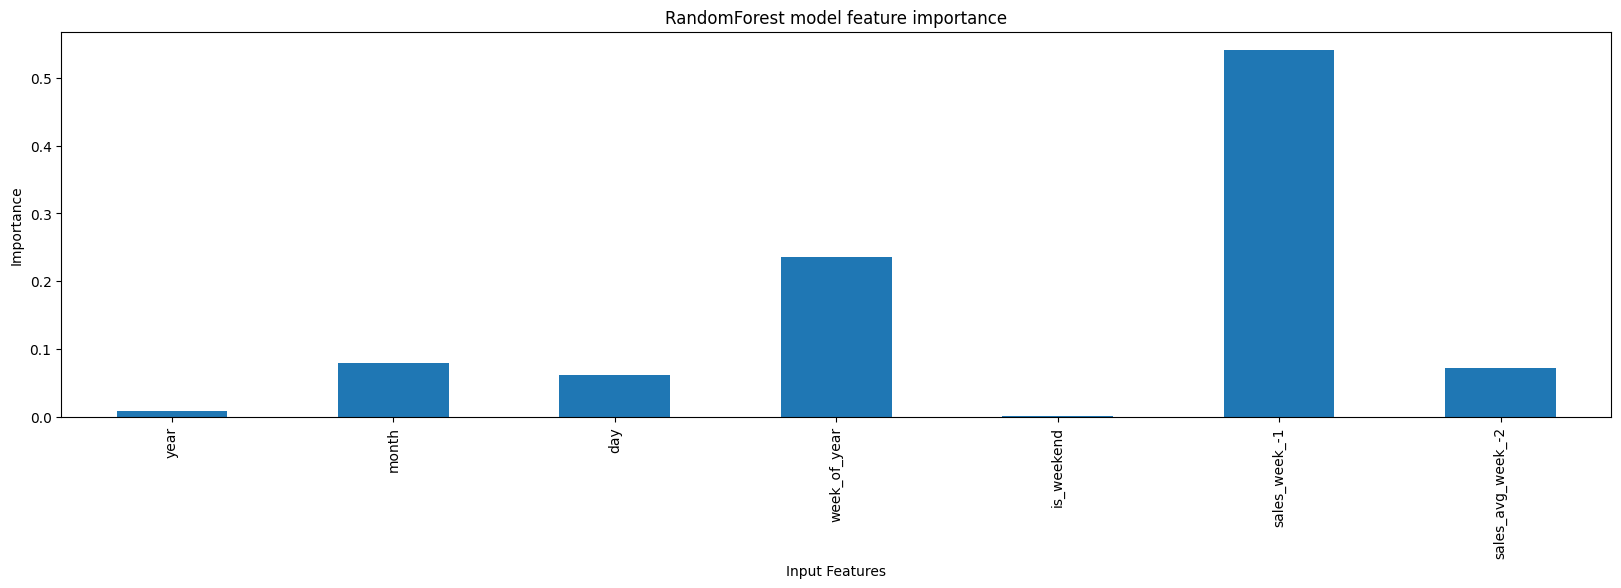

In [193]:
# obtain the feature coefficent values
rf_feat_impt = pd.Series(np.abs(rf_model.feature_importances_))

# add column names in
rf_feat_impt.index = X_train.columns

# plot out the feature coefficients in a bar chart
rf_feat_impt.plot.bar(figsize=(20,5))
plt.title('RandomForest model feature importance')
plt.ylabel('Importance')
plt.xlabel('Input Features')

In [175]:
# second iteration, Lasso regression
lasso_model = Lasso(alpha=1, random_state=RANDOM_STATE)

# fit the training data into model
lasso_model.fit(X_train, y_train)

Lasso(alpha=1, random_state=2)

In [176]:
# perform predictions
ls_train_pred = lasso_model.predict(X_train)
ls_test_pred = lasso_model.predict(X_test)

# evaluate performance of model
ls_train_rmse = mean_squared_error(y_train, ls_train_pred, squared=False)
ls_test_rmse = mean_squared_error(y_test, ls_test_pred, squared=False)

# print the results
print('RMSE of model performance on training data: ', ls_train_rmse)
print('RMSE of model performance on testing data: ', ls_test_rmse)

RMSE of model performance on training data:  41785.21401009532
RMSE of model performance on testing data:  68566.96979444448


Lasso regression did not perform better than RandomForest

Text(0.5, 0, 'Input Features')

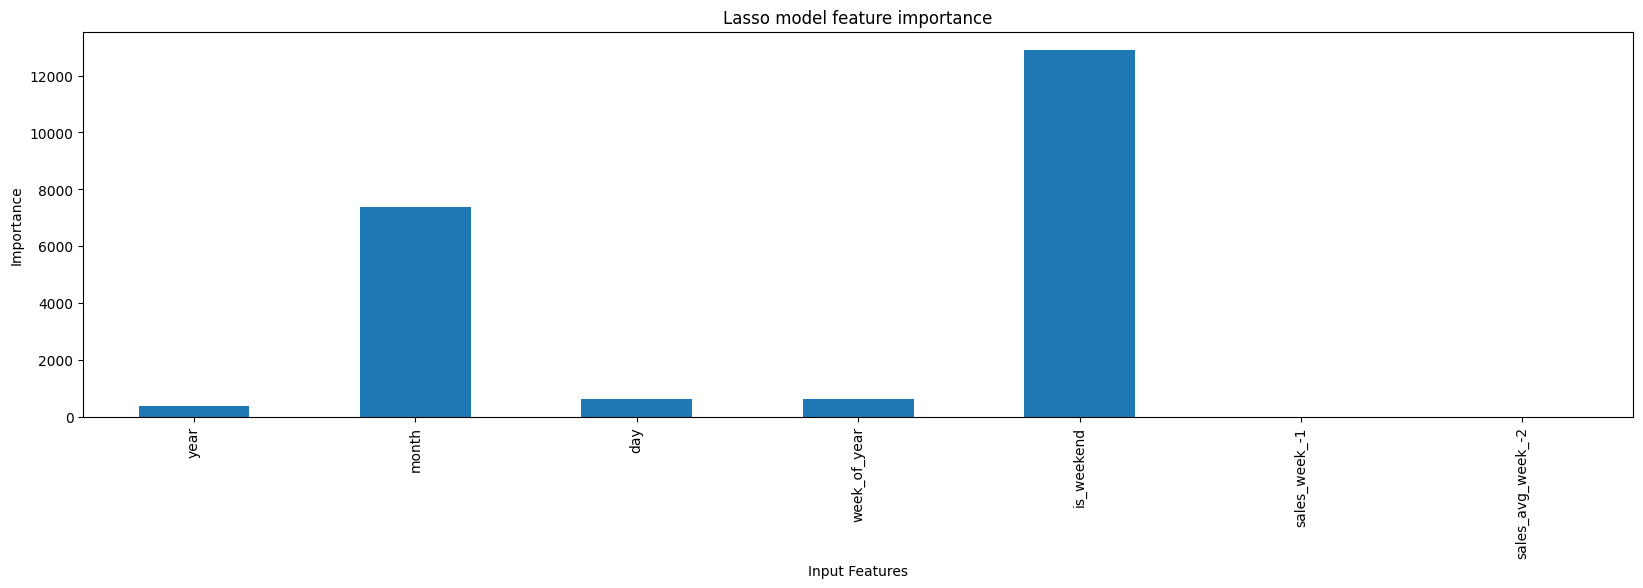

In [191]:
# obtain the feature coefficent values
ls_feat_impt = pd.Series(np.abs(lasso_model.coef_))

# add column names in
ls_feat_impt.index = X_train.columns

# plot out the feature coefficients in a bar chart
ls_feat_impt.plot.bar(figsize=(20,5))
plt.title('Lasso model feature importance')
plt.ylabel('Importance')
plt.xlabel('Input Features')